<a href="https://colab.research.google.com/github/reddyse/HES-Intro-To-Deep-Learning/blob/main/Praneeth_Reddy_Handwritten_OCR_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import libraries

# deep learning libraries
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint



# generic libraries
import pandas as pd
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
from numpy import std

# Dataset
# Manually downloaded dataset from this link and uploaded to my google drive. For some reason when I was download the dataset using Kaggle API token, only some part of the dataset was getting downloaded
# In any case, here is the link alongwith the command to download and unzip the dataset: https://www.kaggle.com/vaibhao/handwritten-characters/download
#!kaggle datasets download -d vaibhao/handwritten-characters
#!unzip handwritten-characters.zip -d handwritten-characters


In [10]:
# mount google drive to get the paths
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/FinalProject"
basedir = '/content/drive/My Drive/Colab Notebooks/FinalProject/'

Mounted at /content/drive


In [13]:
# Load the train dataset from the drive
traindir = basedir+'handwritten-characters/Train/'
train_data = []
img_size = 32 # we will normalize the dataset by resizing the image to 32

# exclude some of the items from the dataset that are not characters.
# I have excluded numbers as well because I am using a seperate MNIST model to detect digits
non_chars = ["#","$","&","0"]

# parse the root directory for character sub-folders that contain images
# also pre-process the image and resize the image to 32
for subdir in os.listdir(traindir):
    if subdir in non_chars: # if the subfolder is a non char, exclude that from processing
        continue
    count = 0
    sub_directory = os.path.join(traindir,subdir)
    for imgfilepath in os.listdir(sub_directory): # loop for each image in the sub directory
        count+=1
        if count > 3500: # if the number is images exceeds 3500, break the loop, for keeping it trainin within permissable limits
            break
        img = cv2.imread(os.path.join(sub_directory,imgfilepath),0) # read the image using OpenCV library
        img = cv2.resize(img,(img_size,img_size)) # re-size the image to 32 X 32 using openCV
        train_data.append([img,subdir]) # store the image matrix and the label in a list

# let's see how much data we got for training
len(train_data)

21374

In [14]:
# Load the validation dataset from the drive
valdir = basedir+'handwritten-characters/Validation/'
val_data = []
img_size = 32 # we will normalize the dataset by resizing the image to 32

# parse the root directory for character sub-folders that contain images
# also pre-process the image and resize the image to 32
for subdir in os.listdir(valdir):
    if subdir in non_chars: # if the subfolder is a non char, exclude that from processing
        continue
    count = 0
    sub_directory = os.path.join(valdir,subdir)
    for imgfilepath in os.listdir(sub_directory): # loop for each image in the sub directory
        count+=1
        if count > 1000: #1000 #500 # if the number is images exceeds 500, break the loop, for keeping it trainin within permissable limits
            break
        img = cv2.imread(os.path.join(sub_directory,imgfilepath),0) # read the image using OpenCV library
        img = cv2.resize(img,(img_size,img_size)) # re-size the image to 32 X 32 using openCV
        val_data.append([img,subdir]) # store the image matrix and the label in a list

# let's see how much data we got for validation
len(val_data)


15841

In [15]:
# re-order/shuffle the data for better training
random.shuffle(train_data)
random.shuffle(val_data)

In [16]:
# parse the lists and create variable to store the features and their corresponding labels

# for training
X_train = []
y_train = []
for features,label in train_data:
    X_train.append(features)
    y_train.append(label)

# for validation
X_val = []
y_val = []
for features,label in val_data:
    X_val.append(features)
    y_val.append(label)

In [17]:
# pre-processing the training and validation data
# in order to normalize labels, I am using LabelBinarizer from sklearn library, this will turn character labels to numerical labels

#Commenting label binarizer due to an issue that I am able to train the model using the this but not able to use it to decode with a saved model at the time of prediction
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.fit_transform(y_val)

# Since labels are now numberic, we can reshape the entire dataset to 32 X 32 using numpy
X_train = np.array(X_train)/255.0
X_train = X_train.reshape(-1,32,32,1)
y_train = np.array(y_train)

X_val = np.array(X_val)/255.0
X_val = X_val.reshape(-1,32,32,1)
y_val = np.array(y_val)

# let's view the shape of the training and validation data
print(X_train.shape,X_val.shape)

(21374, 32, 32, 1) (15841, 32, 32, 1)


In [18]:
# lets define two variable to track the performance of various models we are training
scores, histories = list(), list()

In [20]:
# Come up with a base model and tweak/improve further to make it better

# Base Model 
# let's start with a couple of layers and with gradient descent as optimizer and categorical_crossentropy as loss funtion
model = Sequential()
model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(35, activation='softmax'))
model.summary()

# compile model
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = keras.optimizers.Adam(learning_rate=0.01)
loss_function = 'categorical_crossentropy'
model.compile(optimizer=opt,loss=loss_function, metrics=['accuracy'])

# evaluate the model using k-fold cross-validation
# prepare 
kfold = KFold(5, shuffle=True, random_state=1)
# enumerate splits
# I have used 5 folds to evaluate my model
for train_ix, test_ix in kfold.split(X_train):
  # select rows for train and test
  trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
  # fit model
  history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
  # evaluate model
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))
  # stores scores
  scores.append(acc)
  histories.append(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 35)               

Accuracy (using mean and std dev): mean=94.128 std=1.617, n=5


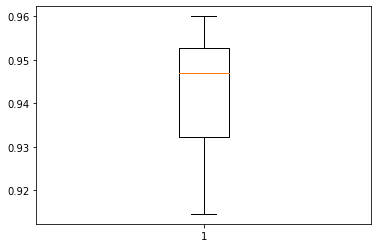

In [21]:
# summary of the model
# print summary
print('Accuracy (using mean and std dev): mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# box and whisker plots of results
plt.boxplot(scores)
plt.show()

In [22]:

# Come up with a third model with some tweaks/improvements to make it better

# First experiment 
# Added some batch normalizations but looks like model is overfitting
# The above results looks too good to be true, maybe the model is overfitting, lets add some dropout layers and see 
# I also changed the optimizer from adam to SGD and seems that has imporoved the accuracy of the model
# I am getting best results with relu activation in the top layers and having softmax in the bottom layer
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(35, activation='softmax'))
model.summary()


# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
#opt = keras.optimizers.Adam(learning_rate=0.01)
loss_function = 'categorical_crossentropy'
model.compile(optimizer=opt,loss=loss_function, metrics=['accuracy'])

# evaluate the model using k-fold cross-validation
# prepare 
kfold = KFold(5, shuffle=True, random_state=1)
# enumerate splits
# I have used 5 folds to evaluate my model
for train_ix, test_ix in kfold.split(X_train):
  # select rows for train and test
  trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
  # fit model
  history = model.fit(trainX, trainY, epochs=75, batch_size=32, validation_data=(testX, testY), verbose=0)
  # evaluate model
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))
  # stores scores
  scores.append(acc)
  histories.append(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

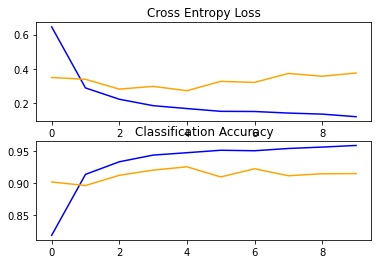

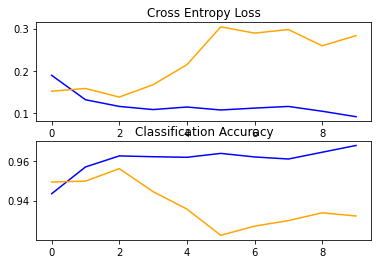

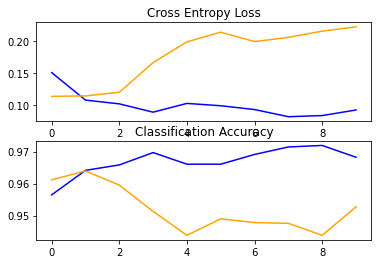

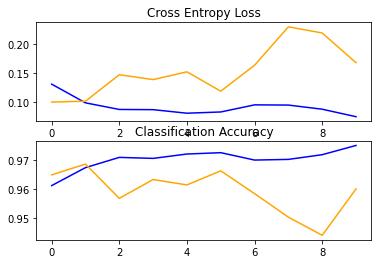

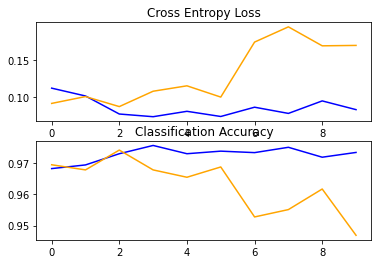

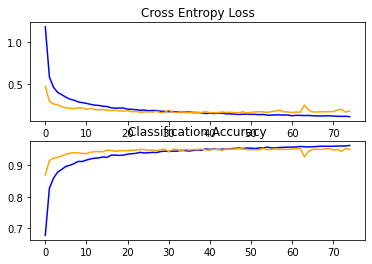

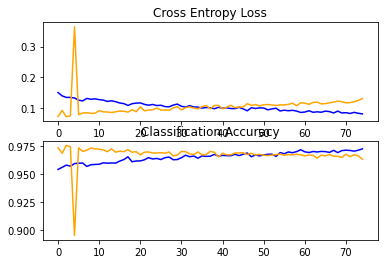

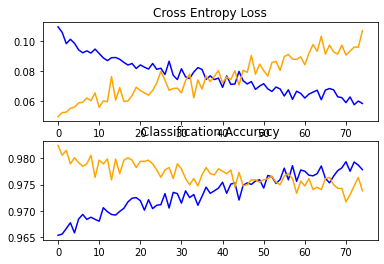

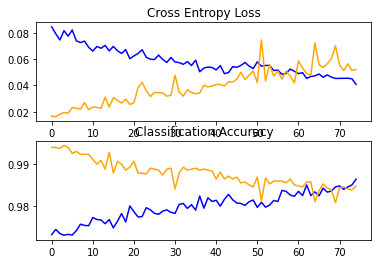

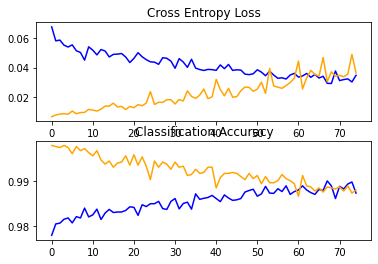

In [23]:
# plot learning curves
for i in range(len(histories)):
  # plot loss
  plt.subplot(2, 1, 1)
  plt.title('Cross Entropy Loss')
  plt.plot(histories[i].history['loss'], color='blue', label='train')
  plt.plot(histories[i].history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(histories[i].history['accuracy'], color='blue', label='train')
  plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()

Accuracy (using mean and std dev): mean=95.679 std=2.153, n=10


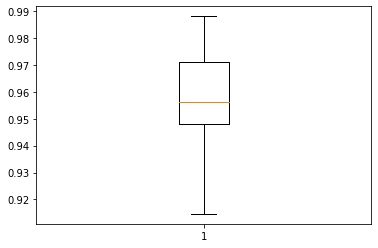

In [24]:
# summary of the model
# print summary
print('Accuracy (using mean and std dev): mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# box and whisker plots of results
plt.boxplot(scores)
plt.show()

In [25]:
# Come up with a third model with some tweaks/improvements to make it better

# Second experiment 
# The above results looks too good to be true, maybe the model is overfitting, removed additonal layers and see 
# I also changed the optimizer from SDO to adam and seems that has imporoved the  model
# I am getting best results with relu activation in the top layers and having softmax in the bottom layer
model = Sequential()
model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.30))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))
model.summary()


# compile model
#opt = SGD(learning_rate=0.01, momentum=0.9)
#opt = keras.optimizers.Adam(learning_rate=0.01)
loss_function = 'categorical_crossentropy'
model.compile(optimizer='adam',loss=loss_function, metrics=['accuracy'])

# evaluate the model using k-fold cross-validation
# prepare 
kfold = KFold(5, shuffle=True, random_state=1)
# enumerate splits
# I have used 5 folds to evaluate my model
for train_ix, test_ix in kfold.split(X_train):
  # select rows for train and test
  trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
  # fit model
  history = model.fit(trainX, trainY, epochs=75, batch_size=32, validation_data=(testX, testY), verbose=0)
  # evaluate model
  _, acc = model.evaluate(testX, testY, verbose=0)
  print('> %.3f' % (acc * 100.0))
  # stores scores
  scores.append(acc)
  histories.append(history)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 128)       

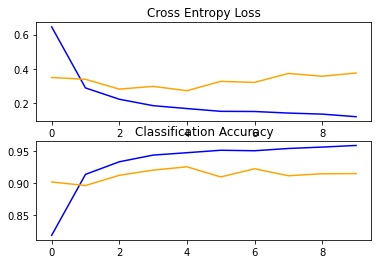

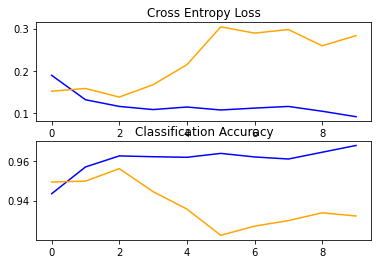

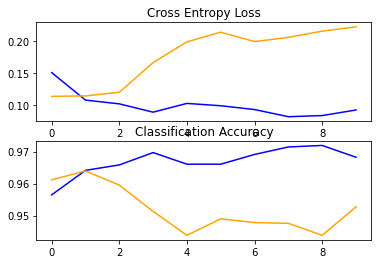

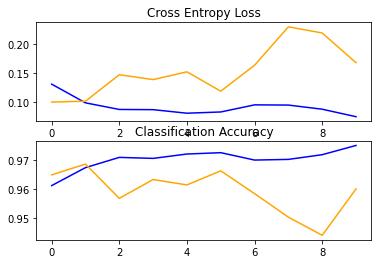

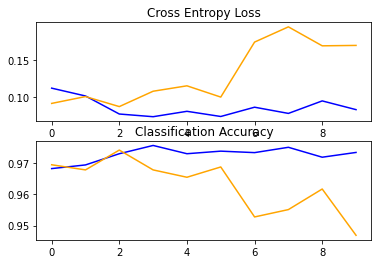

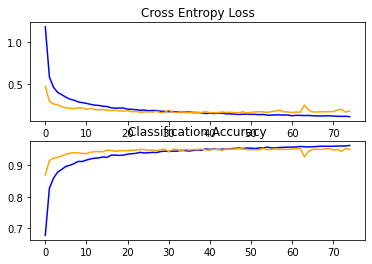

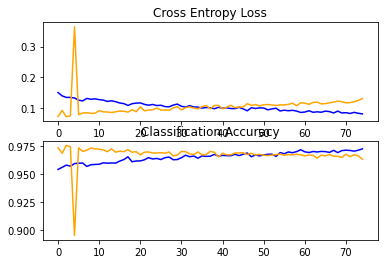

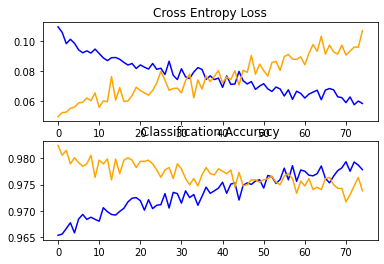

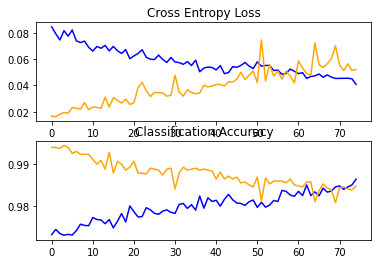

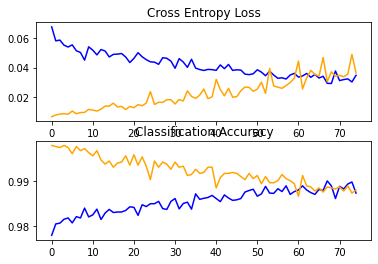

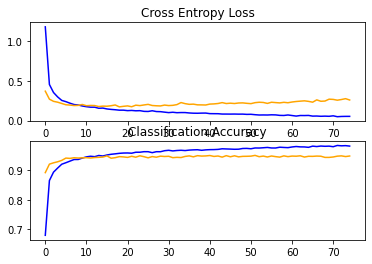

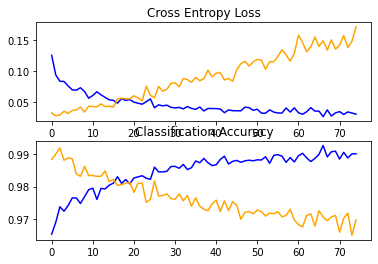

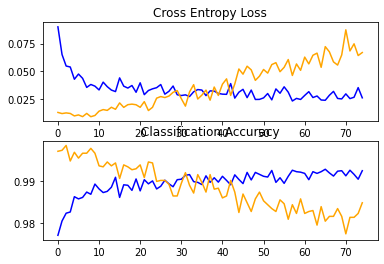

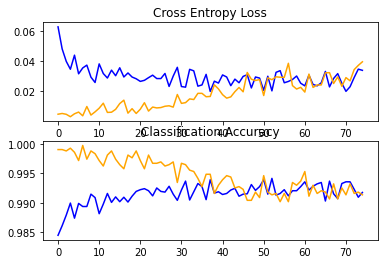

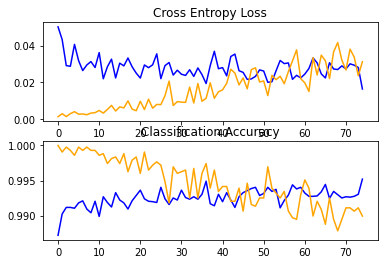

In [26]:
# plot learning curves
for i in range(len(histories)):
  # plot loss
  plt.subplot(2, 1, 1)
  plt.title('Cross Entropy Loss')
  plt.plot(histories[i].history['loss'], color='blue', label='train')
  plt.plot(histories[i].history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(histories[i].history['accuracy'], color='blue', label='train')
  plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()

Accuracy (using mean and std dev): mean=96.338 std=2.210, n=15


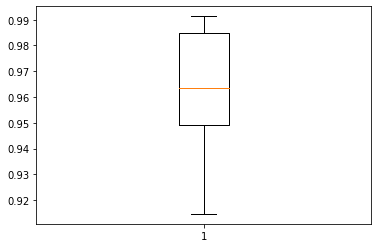

In [27]:
# summary of the model
# print summary
print('Accuracy (using mean and std dev): mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# box and whisker plots of results
plt.boxplot(scores)
plt.show()

In [28]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# variable with the path to the destination folder
dir = '/content/drive/My Drive/Colab Notebooks/FinalProject/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#FINAL TRAINING AND SAVING THE MODEL

# Retrain the model for 75 epochs with callbacks and save it for future use
#modelchkpoint = ModelCheckpoint("C:\\Praneeth\\HarvardExtensionSchool\\Course3IntroToDeepLEarning\\DeepLearningAssignments\\FinalProject\\vscode\\model\\mnistmodelv1.h5", monitor="val_acc", verbose=1, save_best_only= True)
modelchkpoint = ModelCheckpoint(dir+'handwritten_ocr_model_final.h5', monitor="val_acc", verbose=1, save_best_only= True)


# Modifying no. of epochs to 50 as this model is giving best results 
# Earlystopping
# used this callback to stop the training process at highest performing point
earlystopping = EarlyStopping(monitor='val_acc', min_delta =0.01, patience = 4, verbose=1)
cb = [earlystopping,modelchkpoint]
history = model.fit(X_train, y_train, epochs = 75, validation_split=0.3, callbacks=cb)

# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))
# stores scores
scores.append(acc)
histories.append(history)

# save the model for future use
model.save(dir+'handwritten_ocr_model_final.h5')

Epoch 1/75
468/468 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9886

468/468 [==============================] - 3s 6ms/step - loss: 0.0477 - accuracy: 0.9886 - val_loss: 0.0064 - val_accuracy: 0.9981
Epoch 2/75
459/468 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9899

468/468 [==============================] - 3s 5ms/step - loss: 0.0383 - accuracy: 0.9901 - val_loss: 0.0059 - val_accuracy: 0.9980
Epoch 3/75
467/468 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9928

468/468 [==============================] - 3s 6ms/step - loss: 0.0317 - accuracy: 0.9928 - val_loss: 0.0065 - val_accuracy: 0.9978
Epoch 4/75
468/468 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9924

468/468 [==============================] - 3s 5ms/step - loss: 0.0292 - accuracy: 0.9924 - val_loss: 0.0090 - val_accuracy: 0.9964
Epoch 5/75
465/468 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9930

468/468 [==============================] - 3s 6ms/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.0103 - val_accuracy: 0.9970
Epoch 6/75
467/468 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.9908

468/468 [==============================] - 3s 5ms/step - loss: 0.0339 - accuracy: 0.9908 - val_loss: 0.0103 - val_accuracy: 0.9963
Epoch 7/75
468/468 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9929

468/468 [==============================] - 3s 6ms/step - loss: 0.0293 - accuracy: 0.9929 - val_loss: 0.0135 - val_accuracy: 0.9953
Epoch 8/75
464/468 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9914

468/468 [==============================] - 3s 5ms/step - loss: 0.0341 - accuracy: 0.9915 - val_loss: 0.0114 - val_accuracy: 0.9961
Epoch 9/75
465/468 [============================>.] - ETA: 0s - loss: 0.0327 - accuracy: 0.9919

468/468 [==============================] - 3s 5ms/step - loss: 0.0337 - accuracy: 0.9917 - val_loss: 0.0137 - val_accuracy: 0.9963
Epoch 10/75
464/468 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9922

468/468 [==============================] - 3s 5ms/step - loss: 0.0309 - accuracy: 0.9922 - val_loss: 0.0102 - val_accuracy: 0.9969
Epoch 11/75
460/468 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9931

468/468 [==============================] - 3s 5ms/step - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.0100 - val_accuracy: 0.9964
Epoch 12/75
465/468 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.9929

468/468 [==============================] - 3s 6ms/step - loss: 0.0314 - accuracy: 0.9929 - val_loss: 0.0172 - val_accuracy: 0.9939
Epoch 13/75
465/468 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9921

468/468 [==============================] - 3s 5ms/step - loss: 0.0266 - accuracy: 0.9922 - val_loss: 0.0101 - val_accuracy: 0.9967
Epoch 14/75
460/468 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9931

468/468 [==============================] - 3s 6ms/step - loss: 0.0294 - accuracy: 0.9932 - val_loss: 0.0160 - val_accuracy: 0.9947
Epoch 15/75
462/468 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9943

468/468 [==============================] - 3s 6ms/step - loss: 0.0214 - accuracy: 0.9943 - val_loss: 0.0105 - val_accuracy: 0.9972
Epoch 16/75
458/468 [============================>.] - ETA: 0s - loss: 0.0318 - accuracy: 0.9917

468/468 [==============================] - 2s 5ms/step - loss: 0.0315 - accuracy: 0.9917 - val_loss: 0.0109 - val_accuracy: 0.9969
Epoch 17/75
461/468 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9930

468/468 [==============================] - 3s 6ms/step - loss: 0.0272 - accuracy: 0.9930 - val_loss: 0.0141 - val_accuracy: 0.9952
Epoch 18/75
462/468 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9943

468/468 [==============================] - 3s 6ms/step - loss: 0.0245 - accuracy: 0.9941 - val_loss: 0.0122 - val_accuracy: 0.9956
Epoch 19/75
460/468 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9933

468/468 [==============================] - 3s 6ms/step - loss: 0.0275 - accuracy: 0.9933 - val_loss: 0.0141 - val_accuracy: 0.9952
Epoch 20/75
459/468 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9926

468/468 [==============================] - 3s 5ms/step - loss: 0.0246 - accuracy: 0.9928 - val_loss: 0.0127 - val_accuracy: 0.9961
Epoch 21/75
456/468 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9953

468/468 [==============================] - 3s 6ms/step - loss: 0.0202 - accuracy: 0.9953 - val_loss: 0.0157 - val_accuracy: 0.9955
Epoch 22/75
461/468 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9921

468/468 [==============================] - 3s 6ms/step - loss: 0.0354 - accuracy: 0.9921 - val_loss: 0.0132 - val_accuracy: 0.9958
Epoch 23/75
456/468 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.9921

468/468 [==============================] - 3s 6ms/step - loss: 0.0294 - accuracy: 0.9920 - val_loss: 0.0161 - val_accuracy: 0.9944
Epoch 24/75
459/468 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9933

468/468 [==============================] - 3s 6ms/step - loss: 0.0281 - accuracy: 0.9930 - val_loss: 0.0110 - val_accuracy: 0.9967
Epoch 25/75
460/468 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9944

468/468 [==============================] - 3s 5ms/step - loss: 0.0220 - accuracy: 0.9943 - val_loss: 0.0131 - val_accuracy: 0.9959
Epoch 26/75
467/468 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9933

468/468 [==============================] - 3s 6ms/step - loss: 0.0290 - accuracy: 0.9933 - val_loss: 0.0121 - val_accuracy: 0.9958
Epoch 27/75
468/468 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9932

468/468 [==============================] - 3s 6ms/step - loss: 0.0263 - accuracy: 0.9932 - val_loss: 0.0116 - val_accuracy: 0.9952
Epoch 28/75
463/468 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9948

468/468 [==============================] - 3s 6ms/step - loss: 0.0210 - accuracy: 0.9947 - val_loss: 0.0146 - val_accuracy: 0.9953
Epoch 29/75
457/468 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9934

468/468 [==============================] - 3s 5ms/step - loss: 0.0267 - accuracy: 0.9934 - val_loss: 0.0171 - val_accuracy: 0.9947
Epoch 30/75
467/468 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9940

468/468 [==============================] - 3s 6ms/step - loss: 0.0278 - accuracy: 0.9940 - val_loss: 0.0202 - val_accuracy: 0.9933
Epoch 31/75
468/468 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9943

468/468 [==============================] - 3s 6ms/step - loss: 0.0237 - accuracy: 0.9943 - val_loss: 0.0189 - val_accuracy: 0.9941
Epoch 32/75
468/468 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9937

468/468 [==============================] - 3s 5ms/step - loss: 0.0261 - accuracy: 0.9937 - val_loss: 0.0239 - val_accuracy: 0.9935
Epoch 33/75
457/468 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9941

468/468 [==============================] - 3s 6ms/step - loss: 0.0235 - accuracy: 0.9941 - val_loss: 0.0228 - val_accuracy: 0.9938
Epoch 34/75
466/468 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9930

468/468 [==============================] - 3s 6ms/step - loss: 0.0310 - accuracy: 0.9930 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 35/75
459/468 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9934

468/468 [==============================] - 3s 6ms/step - loss: 0.0311 - accuracy: 0.9935 - val_loss: 0.0147 - val_accuracy: 0.9950
Epoch 36/75
457/468 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9941

468/468 [==============================] - 3s 6ms/step - loss: 0.0267 - accuracy: 0.9941 - val_loss: 0.0225 - val_accuracy: 0.9931
Epoch 37/75
460/468 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.9916

468/468 [==============================] - 3s 6ms/step - loss: 0.0324 - accuracy: 0.9916 - val_loss: 0.0179 - val_accuracy: 0.9941
Epoch 38/75
460/468 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9946

468/468 [==============================] - 3s 5ms/step - loss: 0.0222 - accuracy: 0.9947 - val_loss: 0.0225 - val_accuracy: 0.9931
Epoch 39/75
463/468 [============================>.] - ETA: 0s - loss: 0.0305 - accuracy: 0.9926

468/468 [==============================] - 3s 6ms/step - loss: 0.0304 - accuracy: 0.9926 - val_loss: 0.0160 - val_accuracy: 0.9953
Epoch 40/75
464/468 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9952

468/468 [==============================] - 3s 6ms/step - loss: 0.0171 - accuracy: 0.9951 - val_loss: 0.0198 - val_accuracy: 0.9938
Epoch 41/75
467/468 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9930

468/468 [==============================] - 3s 5ms/step - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.0135 - val_accuracy: 0.9964
Epoch 42/75
460/468 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9954

468/468 [==============================] - 3s 6ms/step - loss: 0.0159 - accuracy: 0.9954 - val_loss: 0.0196 - val_accuracy: 0.9941
Epoch 43/75
463/468 [============================>.] - ETA: 0s - loss: 0.0262 - accuracy: 0.9941

468/468 [==============================] - 3s 6ms/step - loss: 0.0273 - accuracy: 0.9940 - val_loss: 0.0174 - val_accuracy: 0.9945
Epoch 44/75
462/468 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9935

468/468 [==============================] - 3s 5ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 0.0240 - val_accuracy: 0.9928
Epoch 45/75
457/468 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9938

468/468 [==============================] - 3s 6ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0216 - val_accuracy: 0.9939
Epoch 46/75
458/468 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9943

468/468 [==============================] - 3s 6ms/step - loss: 0.0218 - accuracy: 0.9943 - val_loss: 0.0227 - val_accuracy: 0.9925
Epoch 47/75
460/468 [============================>.] - ETA: 0s - loss: 0.0322 - accuracy: 0.9920

468/468 [==============================] - 3s 6ms/step - loss: 0.0322 - accuracy: 0.9920 - val_loss: 0.0248 - val_accuracy: 0.9922
Epoch 48/75
460/468 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9928

468/468 [==============================] - 3s 6ms/step - loss: 0.0284 - accuracy: 0.9928 - val_loss: 0.0326 - val_accuracy: 0.9913
Epoch 49/75
468/468 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9933

468/468 [==============================] - 3s 5ms/step - loss: 0.0276 - accuracy: 0.9933 - val_loss: 0.0271 - val_accuracy: 0.9903
Epoch 50/75
462/468 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9943

468/468 [==============================] - 3s 6ms/step - loss: 0.0209 - accuracy: 0.9944 - val_loss: 0.0330 - val_accuracy: 0.9905
Epoch 51/75
462/468 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9935

468/468 [==============================] - 3s 5ms/step - loss: 0.0253 - accuracy: 0.9934 - val_loss: 0.0346 - val_accuracy: 0.9902
Epoch 52/75
460/468 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9936

468/468 [==============================] - 3s 5ms/step - loss: 0.0268 - accuracy: 0.9934 - val_loss: 0.0340 - val_accuracy: 0.9905
Epoch 53/75
462/468 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9947

468/468 [==============================] - 3s 6ms/step - loss: 0.0199 - accuracy: 0.9948 - val_loss: 0.0278 - val_accuracy: 0.9925
Epoch 54/75
461/468 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9932

468/468 [==============================] - 3s 6ms/step - loss: 0.0250 - accuracy: 0.9930 - val_loss: 0.0259 - val_accuracy: 0.9925
Epoch 55/75
464/468 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9938

468/468 [==============================] - 3s 6ms/step - loss: 0.0235 - accuracy: 0.9938 - val_loss: 0.0357 - val_accuracy: 0.9896
Epoch 56/75
468/468 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9928

468/468 [==============================] - 3s 6ms/step - loss: 0.0261 - accuracy: 0.9928 - val_loss: 0.0258 - val_accuracy: 0.9935
Epoch 57/75
461/468 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9931

468/468 [==============================] - 4s 8ms/step - loss: 0.0312 - accuracy: 0.9930 - val_loss: 0.0359 - val_accuracy: 0.9888
Epoch 58/75
459/468 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9926

468/468 [==============================] - 3s 6ms/step - loss: 0.0312 - accuracy: 0.9924 - val_loss: 0.0371 - val_accuracy: 0.9902
Epoch 59/75
465/468 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9943

468/468 [==============================] - 3s 6ms/step - loss: 0.0203 - accuracy: 0.9943 - val_loss: 0.0453 - val_accuracy: 0.9886
Epoch 60/75
458/468 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9925

468/468 [==============================] - 3s 6ms/step - loss: 0.0314 - accuracy: 0.9924 - val_loss: 0.0376 - val_accuracy: 0.9897
Epoch 61/75
462/468 [============================>.] - ETA: 0s - loss: 0.0334 - accuracy: 0.9932

468/468 [==============================] - 3s 6ms/step - loss: 0.0332 - accuracy: 0.9932 - val_loss: 0.0408 - val_accuracy: 0.9878
Epoch 62/75
459/468 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9954

468/468 [==============================] - 3s 6ms/step - loss: 0.0206 - accuracy: 0.9955 - val_loss: 0.0204 - val_accuracy: 0.9938
Epoch 63/75
468/468 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9944

468/468 [==============================] - 3s 6ms/step - loss: 0.0220 - accuracy: 0.9944 - val_loss: 0.0374 - val_accuracy: 0.9889
Epoch 64/75
460/468 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9938

468/468 [==============================] - 3s 6ms/step - loss: 0.0261 - accuracy: 0.9939 - val_loss: 0.0212 - val_accuracy: 0.9927
Epoch 65/75
468/468 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9941

468/468 [==============================] - 3s 5ms/step - loss: 0.0238 - accuracy: 0.9941 - val_loss: 0.0401 - val_accuracy: 0.9885
Epoch 66/75
461/468 [============================>.] - ETA: 0s - loss: 0.0298 - accuracy: 0.9932

468/468 [==============================] - 3s 6ms/step - loss: 0.0295 - accuracy: 0.9932 - val_loss: 0.0393 - val_accuracy: 0.9881
Epoch 67/75
462/468 [============================>.] - ETA: 0s - loss: 0.0236 - accuracy: 0.9938

468/468 [==============================] - 3s 5ms/step - loss: 0.0240 - accuracy: 0.9939 - val_loss: 0.0361 - val_accuracy: 0.9897
Epoch 68/75
463/468 [============================>.] - ETA: 0s - loss: 0.0236 - accuracy: 0.9940

468/468 [==============================] - 3s 6ms/step - loss: 0.0234 - accuracy: 0.9941 - val_loss: 0.0395 - val_accuracy: 0.9883
Epoch 69/75
463/468 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9935

468/468 [==============================] - 3s 6ms/step - loss: 0.0259 - accuracy: 0.9933 - val_loss: 0.0325 - val_accuracy: 0.9910
Epoch 70/75
464/468 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9937

468/468 [==============================] - 3s 5ms/step - loss: 0.0301 - accuracy: 0.9937 - val_loss: 0.0352 - val_accuracy: 0.9902
Epoch 71/75
460/468 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9942

468/468 [==============================] - 3s 5ms/step - loss: 0.0283 - accuracy: 0.9943 - val_loss: 0.0434 - val_accuracy: 0.9875
Epoch 72/75
466/468 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9952

468/468 [==============================] - 3s 6ms/step - loss: 0.0212 - accuracy: 0.9952 - val_loss: 0.0446 - val_accuracy: 0.9892
Epoch 73/75
465/468 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9942

468/468 [==============================] - 3s 5ms/step - loss: 0.0196 - accuracy: 0.9942 - val_loss: 0.0456 - val_accuracy: 0.9894
Epoch 74/75
457/468 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9939

468/468 [==============================] - 3s 6ms/step - loss: 0.0243 - accuracy: 0.9939 - val_loss: 0.0307 - val_accuracy: 0.9908
Epoch 75/75
461/468 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9935

468/468 [==============================] - 3s 6ms/step - loss: 0.0251 - accuracy: 0.9936 - val_loss: 0.0385 - val_accuracy: 0.9888
> 99.485


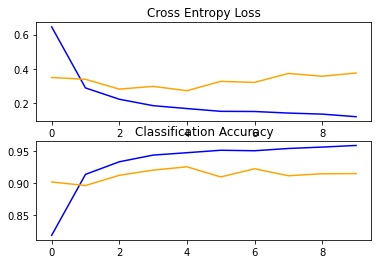

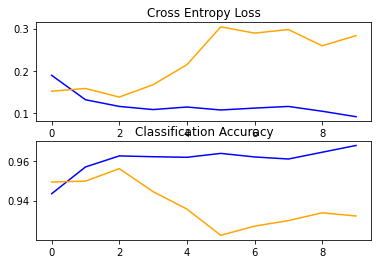

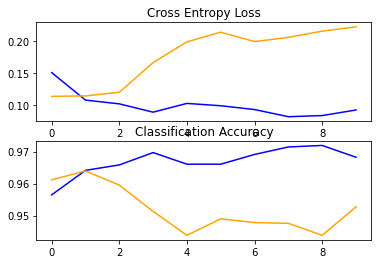

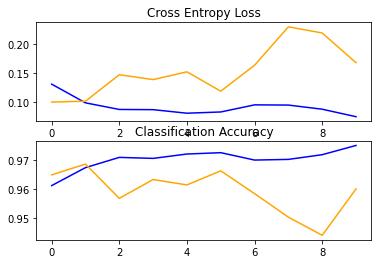

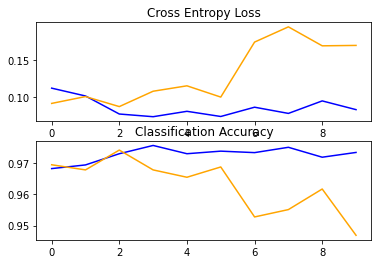

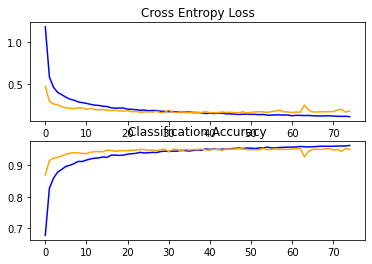

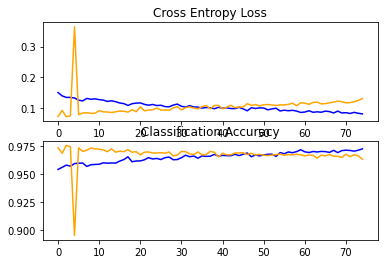

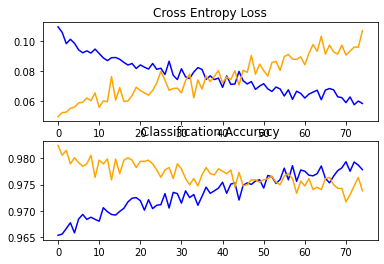

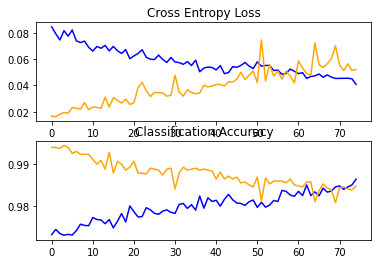

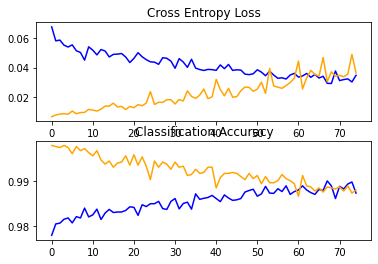

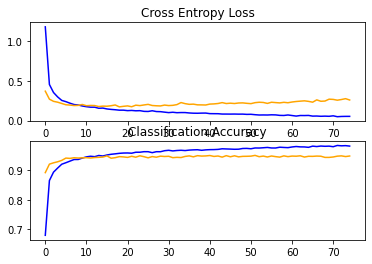

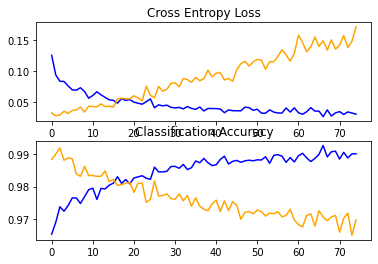

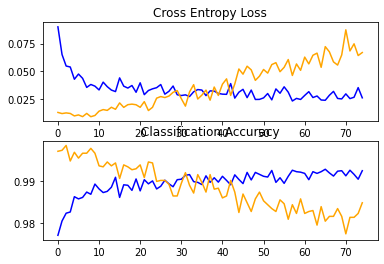

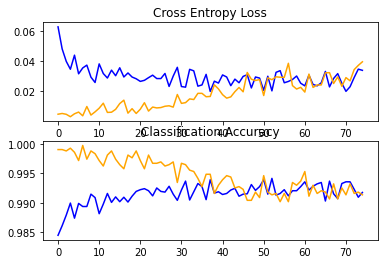

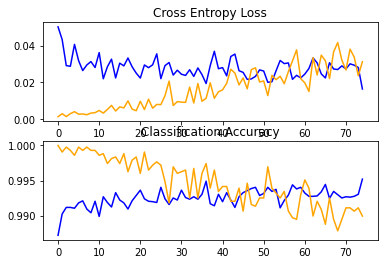

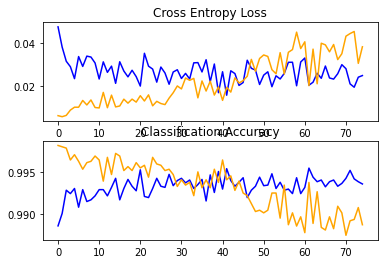

In [30]:
#Evolution of the model through all the experiments

# plot learning curves
for i in range(len(histories)):
  # plot loss
  plt.subplot(2, 1, 1)
  plt.title('Cross Entropy Loss')
  plt.plot(histories[i].history['loss'], color='blue', label='train')
  plt.plot(histories[i].history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(2, 1, 2)
  plt.title('Classification Accuracy')
  plt.plot(histories[i].history['accuracy'], color='blue', label='train')
  plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  plt.show()

Accuracy (using mean and std dev): mean=96.535 std=2.272, n=16


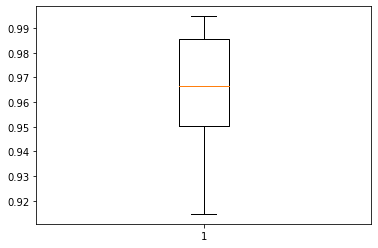

In [31]:
# summary of the model
# print summary
print('Accuracy (using mean and std dev): mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# box and whisker plots of results
plt.boxplot(scores)
plt.show()

In [44]:
# Lets test the model how well its functioning. We will start with creating below custom functions to find contours in the images and split the word into letters


# We also have another funtion that we will be using to break the word into letters 
def get_letters(img):
    letters = []
    image = cv2.imread(img) # read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to gray scale
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV) 
    dilated = cv2.dilate(thresh1, None, iterations=2) # clean the image using dilation

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # find the contours
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0] # call the function created above to sort contours
    
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = label_binarizer.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

def get_word(letter):
    word = " ".join(letter)
    return word

# This is a custom definition to find and sort contours 
# Contours are a curve joining all the continuous points (along the boundary), having same color or intensity. This process helps us to define the shape of the image to which we can apply our model.
# For the image we are passing, the below funtion will return the list of sorted contours with bounding boxes
# I am using a openCv inbuit funtion to do this. 
def sort_contours(cnts, method="left-to-right"): # 'left-to-right' ensures the contours are read starting from left, some languages might demand other directions
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


1/1 [==============================] - 0s 16ms/step
['1', 'D', 'F', 'A', 'N', 'E', 'F', 'M']
1 D F A N E F M


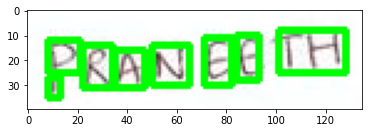

In [50]:
# input word as an imge
letter,image = get_letters('/content/drive/My Drive/Colab Notebooks/FinalProject/handwritten-characters/praneeth_img.JPG')
plt.imshow(image)

print(letter)

# output as a text word
word = get_word(letter)
print(word)
